## Toy example: Inferring the mean of Gaussians

#### comparing the multi-round SNPE approach against our new incremental approach.

Goal of this little toy example is to show that provided our parameters are independent of each other, we need less simulations to derive a good approximation of our parameters.

In [90]:
import sys
sys.path.append('../code/')

import utils
from utils.helpers import get_time
from utils import inference

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

from utils.simulation_wrapper import SimulationWrapper


# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C

import sbi


In [91]:
import os

os.getcwd()

'/home/ubuntu/results/toy_example_mdn_noprob_2'

In [8]:
os.chdir('/home/ubuntu/results/toy_example_mdn_noprob_2')

Defining a function (Gaussian) that takes a arbitrary number of thetas (parameters for a Gaussian mean) and samples from a Gaussian with this mean and a standard deviation of 0.1

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



### Larger comparison with KL-divergence between analytic and inferred posterior

### Calculate posterior for different number of simulations: 1k,  3k, 5k, 10k

### starting with multi-round snpe

In [93]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

In [120]:
num_simulations_list = [200, 750]


In [121]:
obs_real = Gaussian(true_thetas[0])

obs_real


tensor([  1.7214,   7.5067,  20.1647,  10.2150,  89.5417,  56.8306,  26.3957,
         26.6436,   4.6505,  71.9684,   4.8273,  67.2060, 100.3506,  39.6384,
         46.1287], dtype=torch.float64)

In [122]:
from sbi.utils import RestrictionEstimator

In [123]:
torch.manual_seed(4)
list_collection = []

import datetime

obs_real = Gaussian(true_thetas[0])

start = datetime.datetime.now()

for i in range(1):
    

    posterior_snpe_list = []

    for num_simulations in num_simulations_list:
        
        prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
        simulator_stats, prior = prepare_for_sbi(Gaussian, prior)
        
        inf = SNPE_C(prior, density_estimator="mdn")
        
        restriction_estimator = RestrictionEstimator(prior=prior)
        
        proposals = [prior]
        
        num_rounds = 3

        for j in range(num_rounds):
            
            theta, x = simulate_for_sbi(
                simulator_stats,
                proposal=proposals[-1],
                num_simulations=num_simulations,
                num_workers=8,
            )
            restriction_estimator.append_simulations(theta, x)
            if j < num_rounds - 2: # training not needed in last round because classifier will not be used anymore.
                classifier = restriction_estimator.train()
                print('stop')
                
            proposals.append(restriction_estimator.restrict_prior())
            
            
        print('here')   
            
        all_theta, all_x, _ = restriction_estimator.get_simulations()
        
        density_estimator = inf.append_simulations(all_theta, all_x).train()
        
        posterior = inf.build_posterior()

        posterior_snpe = posterior.set_default_x(obs_real)

        posterior_snpe_list.append(posterior_snpe)
        
    list_collection.append(posterior_snpe_list)
    
end = datetime.datetime.now()

diff  = end - start

print(diff)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

stopning neural network. Epochs trained:  791
The classifier rejected 4.6% of all samples. You will get a speed-up of 4.8%.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

The classifier rejected 4.5% of all samples. You will get a speed-up of 4.7%.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

here
Neural network successfully converged after 68 epochs.


Running 750 simulations in 750 batches.:   0%|          | 0/750 [00:00<?, ?it/s]

stopning neural network. Epochs trained:  685
The classifier rejected 11.0% of all samples. You will get a speed-up of 12.4%.


Running 750 simulations in 750 batches.:   0%|          | 0/750 [00:00<?, ?it/s]

The classifier rejected 10.7% of all samples. You will get a speed-up of 12.0%.


Running 750 simulations in 750 batches.:   0%|          | 0/750 [00:00<?, ?it/s]

here
Neural network successfully converged after 424 epochs.
0:11:05.485008


In [109]:
print(diff)

0:18:36.737414


In [113]:
torch.save(list_collection, 'list_collection.pt')

In [13]:
list_collection = torch.load('list_collection.pt')

In [14]:
list_collection

[[DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Size([15])), 1),
                 x_shape=torch.Size([1, 15]))
                 ,
  DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Size([15])), 1),
                 x_shape=torch.Size([1, 15]))
                 ,
  DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Size([15])), 1),
                 x_shape=torch.Size([1, 15]))
                 ,
  DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Si

### For incremental approach: 

In [111]:
range_list = [5,10, 15]

import datetime

list_collection_inc = []


start = datetime.datetime.now()


for i in range(1):
    
    np.random.seed(i)

    posterior_incremental_list = []


    for num_simulations in num_simulations_list:

        prior_i = utils.torchutils.BoxUniform(low=prior_min[0:range_list[0]], high = prior_max[0:range_list[0]])

        
        simulator_stats, prior_i = prepare_for_sbi(Gaussian, prior_i)
        
        inf = SNPE_C(prior_i, density_estimator="mdn")
        
        proposal = prior_i

        start_num = 1

        for index in range(len(range_list)-1):

            ## i defines number of parameters to be inferred, j indicates how many parameters 
            #to come in the next round
            i = range_list[index]
            j = range_list[index+1]

            print(i, j)

            num_sim = int(num_simulations * (start_num / 7))

            start_num += 6

            start_time = datetime.datetime.now()

            theta, x =  simulate_for_sbi(
                simulator_stats,
                proposal=proposal,
                num_simulations=num_simulations,
                num_workers=8,

            )

            inf = inf.append_simulations(theta, x)
            neural_dens = inf.train()

            posterior = inf.build_posterior(neural_dens)

            if i < 2:
                obs_real = Gaussian([true_thetas[0, 0:i]])

            else:
                obs_real = Gaussian(true_thetas[0, 0:i])


            proposal1 = posterior.set_default_x(obs_real)

            next_prior = utils.torchutils.BoxUniform(low=prior_min[i:j], high=prior_max[i:j])

            combined_prior = Combined(proposal1, next_prior, number_params_1=i)


            ## set inf for next round:
            inf = SNPE_C(combined_prior, density_estimator="mdn")


            ## set combined prior to be the new prior_i:
            proposal= combined_prior

            finish_time = datetime.datetime.now()

            diff = finish_time - start_time

            print('took ', diff, ' for this step')

        num_sim = int(num_simulations * (start_num / 7))

        theta, x =  simulate_for_sbi(
            simulator_stats,
            proposal=proposal,
            num_simulations=num_sim,
            num_workers=8,

        )

        inf = inf.append_simulations(theta, x)
        neural_dens = inf.train()

        posterior_incremental = inf.build_posterior(neural_dens) 

        posterior_incremental_list.append(posterior_incremental)
        
    list_collection_inc.append(posterior_incremental_list)
    
    
end = datetime.datetime.now()

diff  = end - start

print(diff)


5 10


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Neural network successfully converged after 129 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

took  0:00:02.969460  for this step
10 15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Neural network successfully converged after 41 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

took  0:00:05.540664  for this step


Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Running 371 simulations in 371 batches.:   0%|          | 0/371 [00:00<?, ?it/s]

Neural network successfully converged after 26 epochs.
5 10


Running 600 simulations in 600 batches.:   0%|          | 0/600 [00:00<?, ?it/s]

Neural network successfully converged after 95 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

took  0:00:04.953893  for this step
10 15


Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Running 600 simulations in 600 batches.:   0%|          | 0/600 [00:00<?, ?it/s]

Neural network successfully converged after 80 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

took  0:00:30.711279  for this step


Drawing 1114 posterior samples:   0%|          | 0/1114 [00:00<?, ?it/s]

Running 1114 simulations in 1114 batches.:   0%|          | 0/1114 [00:00<?, ?it/s]

Neural network successfully converged after 78 epochs.
5 10


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 69 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

took  0:00:06.202922  for this step
10 15


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 156 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

took  0:01:48.754000  for this step


Drawing 1857 posterior samples:   0%|          | 0/1857 [00:00<?, ?it/s]

Running 1857 simulations in 1857 batches.:   0%|          | 0/1857 [00:00<?, ?it/s]

Neural network successfully converged after 94 epochs.
0:05:10.423422


In [112]:
torch.save(list_collection_inc, 'list_collection_inc.pt')

In [15]:
list_collection_inc = torch.load('list_collection_inc.pt')

In [16]:
import torch.nn.functional as F


#out = F.kl_div(analytic_sample, posterior_sample)

In [17]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [18]:
import torch

analytic = torch.distributions.normal.Normal(true_thetas, 1)

analytic.stddev

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [116]:
print(sbi.__version__)

0.17.0


In [119]:
list_collection

[]

In [117]:



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL = KL_Gauss(posterior_snpe, analytic)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

In [118]:
obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL = KL_Gauss(posterior_incremental, analytic)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [115]:
len(overall_incremental_list)

1

In [87]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]


In [88]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [68]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

In [69]:
lower_snpe

array([99.38450165, 95.73804321, 36.53646088, 14.01561317, 12.37797699,
       13.41503563])

In [55]:
num_simulations_list = num_simulations_list[1:]
mean_snpe = mean_snpe[1:]
mean_incremental = mean_incremental[1:]
stdev_snpe = stdev_snpe[1:]
lower_snpe = lower_snpe[1:]
upper_snpe = upper_snpe[1:]
stdev_incremental = stdev_incremental[1:]
lower_incremental = lower_incremental[1:]
upper_incremental = upper_incremental[1:]

### Compare KL-divergence of snpe approach with incremental approach in a plot:

#### x = number of simulations per round/step

Text(0.5, 0, 'simulations per round')

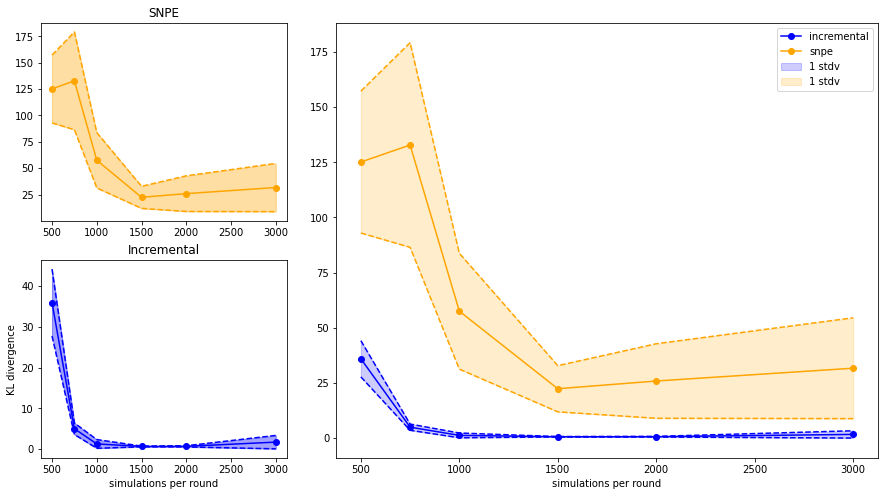

In [89]:
figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

    

axes['B'].plot(num_simulations_list, mean_incremental, '-o', color='blue')
axes['A'].plot(num_simulations_list, mean_snpe, '-o',  color='orange')

axes['B'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['B'].plot(num_simulations_list, lower_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='blue')
axes['C'].plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='orange')

axes['C'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['C'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['C'].plot(num_simulations_list, lower_incremental, '--',  color='blue')
axes['C'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2,  label='1 stdv')
axes['C'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2, label='1 stdv')


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


#plt.title('KL loss')
#axes['A'].legend()
#axes['B'].legend()
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

axes['A'].set_title('SNPE')
axes['B'].set_title('Incremental')

#axes['A'].set_ylim((-5, 120))
#axes['B'].set_ylim((-5, 120))
#axes['C'].set_ylim((-5, 120))

axes['C'].set_xlabel('simulations per round')


#axes['B'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['A'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['C'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#plt.xticks(['1k', '3k', '5k', '10k'])

In [83]:
mean_incremental = np.log(mean_incremental)

mean_snpe = np.log(mean_snpe)

lower_snpe = np.log(lower_snpe)

upper_snpe = np.log(upper_snpe)

lower_incremental = np.log(lower_incremental)

upper_incremental = np.log(upper_incremental)

Text(0.5, 1.0, 'Incremental')

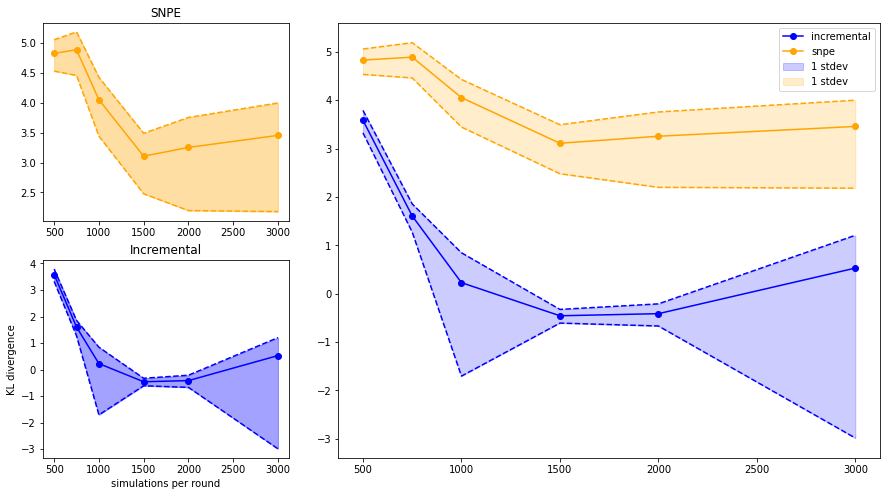

In [86]:
figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

    

axes['B'].plot(num_simulations_list, mean_incremental, '-o', color='blue')
axes['A'].plot(num_simulations_list, mean_snpe, '-o',  color='orange')

axes['B'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['B'].plot(num_simulations_list, lower_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='blue')
axes['C'].plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='orange')

axes['C'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['C'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['C'].plot(num_simulations_list, lower_incremental, '--',  color='blue')
axes['C'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2, label='1 stdev')
axes['C'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2, label='1 stdev')


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


#plt.title('KL loss')
#axes['A'].legend()
#axes['B'].legend()
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

axes['A'].set_title('SNPE')
axes['B'].set_title('Incremental')

#axes['A'].set_ylim((-0.5, 5))
#axes['B'].set_ylim((-0.5, 5))
#axes['C'].set_ylim((-0.5, 5))


#axes['B'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['A'].set_xticklabels(['0k','2k', '4k', '6

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: only one element tensors can be converted to Python scalars

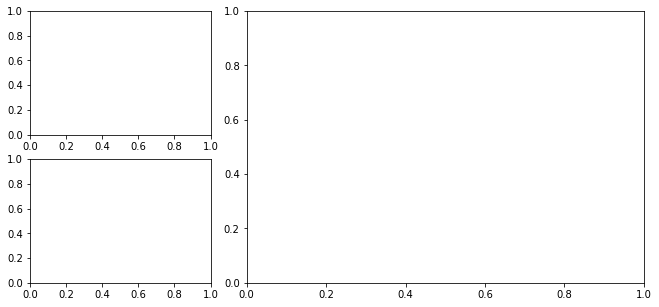

In [44]:
import matplotlib as mpl

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(11, 5))

    


for j in range(8):

    axes['A'].plot(num_simulations_list, [i[j] for i in KL_snpe_1d], '--o', color='orange', alpha=0.4)
    axes['B'].plot(num_simulations_list, [i[j] for i in KL_incremental_1d], '--o', color='blue', alpha=0.4)
    
    axes['C'].plot(num_simulations_list, [i[j] for i in KL_snpe_1d], '--o', color='orange', alpha=1)
    axes['C'].plot(num_simulations_list, [i[j] for i in KL_incremental_1d], '--o', color='blue', alpha=0.4)

    
axes['A'].legend(['snpe'])
axes['B'].legend(['incremental'])
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')